In [1]:
%%capture
#additional data from https://github.com/nflverse/nfl_data_py

!jupyter nbextension enable --py widgetsnbextension

In [2]:
#immport necessary libraries and filter warnings
from IPython.display import Image
import gc
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, cohen_kappa_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from colorama import Fore, Style
from tqdm import tqdm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer, KNNImputer
from utility_db_25 import mark_columns, TrainML, calculate_and_plot_metrics, optuna_call

In [3]:
!pip install pyarrow==17.0.0

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment. 

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [4]:
#helper functions
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 18:
        return deg - 180

#merge all data specifically to pull the data for the team in possession during the play
def merge_clean_data(df_tracking, df_plays, df_player_plays):
    df_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=[ 'gameId', 'playId','club'], right_on=[ 'gameId', 'playId', 'possessionTeam'], how='inner'), df_player_plays, left_on=[ 'gameId', 'playId', 'nflId'], right_on=[ 'gameId', 'playId', 'nflId'], how='left' )
    df_final=pd.merge(df_final, df_games, on='gameId', how='inner')
    del df_tracking
    gc.collect()
    df_final=pd.merge(df_final, df_players, on='nflId', how='inner')
    return df_final

In [5]:
nfl.import_pbp_data(years=[2022])

2022 done.
Downcasting floats.


,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,,,0,0,NaN,NaN,None,None,None,None
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11,11,NaN,NaN,None,None,None,None
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,NaN,NaN,None,None,None,None
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,0.56,3.070,True,ANGLE,ZONE_COVERAGE,COVER_2
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49429,4035.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,None,None,None,...,,,0,0,NaN,NaN,None,None,None,None
49430,4024.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,KC,away,PHI,...,00-0030615;00-0034752;00-0036230;00-0036623;00...,00-0036813;00-0037073;00-0036917;00-0037615;00...,11,11,NaN,NaN,None,None,None,None
49431,4050.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,00-0035157;00-0037198;00-0037819;00-0038043;00...,00-0036813;00-0036919;00-0033251;00-0036917;00...,11,11,NaN,NaN,None,None,None,None
49432,4072.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,00-0036271;00-0034351;00-0032954;00-0036919;00...,00-0036374;00-0035157;00-0035625;00-0037819;00...,11,11,NaN,6.073,False,None,ZONE_COVERAGE,PREVENT


In [6]:
#read games, players, plays, and player_plays data
file='data/'
df_games=pd.read_csv(file+'games.csv')
df_players=pd.read_csv(file+'players.csv')
df_players.loc[df_players['nflId'] ==45244, 'position'] = 'TE' #update data for Taysom Hill
df_plays=pd.read_csv(file+'plays.csv')
#pull stadium data for current season games
df_stadium=nfl.import_schedules([2022])
df_stadium=df_stadium[df_stadium['week']<=9][[ 'old_game_id','roof', 'surface']]

#get game weather
df_games_weather=nfl.import_pbp_data(years=[2022])[['old_game_id_x',  'weather' ]].drop_duplicates()
df_games_weather['gameId']=df_games_weather['old_game_id_x'].astype(int)
df_games_weather['Rain']=np.where(df_games_weather['weather'].str.contains('Rain'), 1, 0)
df_games_weather[['temp', 'humidity', 'wind']]=df_games_weather['weather'].str.split(',', expand=True).iloc[:, :3]
df_games_weather['temp'] = df_games_weather['temp'].str.split(':', expand=True).iloc[:, 1:2]
df_games_weather['temp']=df_games_weather['temp'].str.extract('(\d+)')
df_games_weather['humidity'] = df_games_weather['humidity'].str.extract('(\d+)')
df_games_weather['wind'] = df_games_weather['wind'].str.extract('(\d+)')

df_games=pd.merge(df_games, df_stadium,left_on='gameId', right_on='old_game_id', how='left')
df_games=pd.merge(df_games, df_games_weather,on='gameId', how='left')



2022 done.
Downcasting floats.


In [7]:
#pull previous year pass rush data by team
df_player_plays=pd.read_csv(file+'player_play.csv')
df_rush2021=nfl.import_ngs_data(stat_type='rushing', years=[2021])[['team_abbr', 'rush_attempts']].groupby('team_abbr').sum().reset_index()
df_pass2021=nfl.import_ngs_data(stat_type='passing', years=[2021])[['team_abbr', 'attempts']].groupby('team_abbr').sum().reset_index()
df_pass_rush2021=pd.merge(df_rush2021, df_pass2021, on='team_abbr', how='outer')
df_pass_rush2021['pass_rush_ratio']=np.round((df_pass_rush2021['attempts']/df_pass_rush2021['rush_attempts']), 2)
df_pass_rush2021.drop(columns=['rush_attempts', 'attempts'], inplace=True)
df_player_plays=pd.merge(df_player_plays, df_pass_rush2021, left_on='teamAbbr', right_on='team_abbr', how='outer')


In [8]:
#features for plays df 
df_plays['time_remaining'] = df_plays['quarter'].map({1: 45, 2: 30, 3: 15, 4: 0}) + \
                               df_plays['gameClock'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
df_plays['score_differential'] = df_plays['preSnapHomeScore'] - df_plays['preSnapVisitorScore']

In [9]:
exclude_events=['huddle_break_offense'] #exclude frame with huddle break event
tracking_files=[]
for i in range(1,9):  #read some or all of weeks tracking data
    file='data/tracking_week_'+str(i)+'.csv'
    df_tracking=pd.read_csv(file)
    df_tracking=df_tracking[ (df_tracking['frameType']=='BEFORE_SNAP')& (~df_tracking['event'].isin(exclude_events))]
    df_tracking['gameplayId']=df_tracking['gameId'].astype(str)+'_'+df_tracking['playId'].astype(str)
    playstodrop=df_tracking[df_tracking['event'].isin(['huddle_start_offense', 'timeout_away'])][['gameplayId']].drop_duplicates() #plays with huddle start or timeout we should drop
    df_tracking = df_tracking[~df_tracking['gameplayId'].isin(playstodrop['gameplayId'])]
    
    #nromalize o, dir, x, y
    df_tracking['o_standard']=np.where(df_tracking["playDirection"] == "left",df_tracking['o'].apply(reverse_deg), df_tracking['o'])
    df_tracking['dir_standard']=np.where(df_tracking["playDirection"] == "left",df_tracking['dir'].apply(reverse_deg), df_tracking['dir'])
    df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
    df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
   
    df_tracking=df_tracking[['gameId', 'playId', 'nflId','club' ,'o_standard', 'dir_standard', 'x_standard', 'y_standard', 's', 'a', 'dis']].groupby(['gameId', 'playId', 'nflId','club']).agg({'s':[ 'max',],'a':[ 'max'], 
    'o_standard':['mean', 'std'],'dis':['sum'],'dir_standard':['mean', 'std'], 'x_standard':['mean', 'std'], 'y_standard':['mean', 'std']}).reset_index()
    df_tracking.columns=df_tracking.columns.map('|'.join).str.strip('|')
    #filter on before snap and exclude the specific events
    #merge all data
    merged=merge_clean_data(df_tracking, df_plays, df_player_plays)
    del df_tracking
    #drop unnecessary columns to save memory
    merged.drop(columns=[   'playDescription',
          'possessionTeam', 'defensiveTeam',
           'yardlineSide', 'yardlineNumber', 'gameClock', 
             'expectedPoints',
          'playClockAtSnap',
          'passLength', 'targetX', 'targetY', 'playAction',
           'dropbackType', 'dropbackDistance', 'passLocationType',
           'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
           'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
           'rushLocationType', 'penaltyYards_x', 'prePenaltyYardsGained',
           'yardsGained', 'homeTeamWinProbabilityAdded',
           'visitorTeamWinProbilityAdded', 'expectedPointsAdded',
            'pff_runConceptPrimary', 'pff_runConceptSecondary',
           'pff_runPassOption', 'pff_passCoverage',  'teamAbbr',
           'hadRushAttempt', 'rushingYards', 'hadDropback', 'passingYards',
           'sackYardsAsOffense', 'hadPassReception', 'receivingYards',
           'wasTargettedReceiver', 'yardageGainedAfterTheCatch', 'fumbles',
           'fumbleLost', 'fumbleOutOfBounds', 'assistedTackle',
           'forcedFumbleAsDefense', 'halfSackYardsAsDefense', 'passDefensed',
           'quarterbackHit', 'sackYardsAsDefense', 'safetyAsDefense',
           'soloTackle', 'tackleAssist', 'tackleForALoss',
           'tackleForALossYardage', 'hadInterception', 'interceptionYards',
           'fumbleRecoveries', 'fumbleRecoveryYards', 'penaltyYards_y',
           'penaltyNames', 'wasInitialPassRusher', 'causedPressure',
           'timeToPressureAsPassRusher', 'getOffTimeAsPassRusher',
           'inMotionAtBallSnap', 
           'wasRunningRoute', 'routeRan', 'blockedPlayerNFLId1','pff_manZone',
           'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
           'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker',
           'pff_defensiveCoverageAssignment',
           'pff_primaryDefensiveCoverageMatchupNflId',
           'pff_secondaryDefensiveCoverageMatchupNflId', 'height', 'weight','season', 'team_abbr',  'season', 'week',
       'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr',
       'homeFinalScore', 'visitorFinalScore', 'old_game_id', 'old_game_id_x', 'weather',
           'birthDate', 'collegeName'], inplace=True)
        #get the count of players in each position for each play and take the max
    merged['pos_count']=(merged[['gameId', 'playId', 'position', 'nflId']].drop_duplicates().sort_values(by=['gameId', 'playId', 'position']).groupby(by=['gameId', 'playId', 'position']).cumcount()+1)
    merged['pos_count'].fillna(99, inplace=True)
    merged['pos_count']=merged['pos_count'].astype(int)
    #create a position_pivot column so that each player has a unique value during the play
    merged['position_pivot']=merged['position']+'_'+merged['pos_count'].astype(str)
    tracking_files.append(merged)
    del merged
    gc.collect()
merged=pd.concat(tracking_files)

In [10]:
#create 'pass' variable for pass attempt play based on isDropback=True

merged['pass']=np.where(merged['isDropback']==True, 1, 0)


In [11]:
merged_pivot=merged.pivot(index=['gameId', 'playId','quarter', 'down', 'yardsToGo', 'score_differential', 'time_remaining', 'playNullifiedByPenalty','preSnapHomeTeamWinProbability', 'pass_rush_ratio', 'roof', 'surface', 'Rain', 'temp', 'humidity', 'wind',
           'preSnapVisitorTeamWinProbability',
           'absoluteYardlineNumber', 'offenseFormation', 'receiverAlignment',
           'pass'], columns=['position_pivot'], values=['s|max', 'a|max',
       'o_standard|mean', 'o_standard|std', 'dis|sum', 'dir_standard|mean',
       'dir_standard|std', 'x_standard|mean', 'x_standard|std',
       'y_standard|mean', 'y_standard|std', 'shiftSinceLineset', 'motionSinceLineset']).fillna(0).reset_index() 
merged_pivot.columns =merged_pivot.columns.map('|'.join).str.strip('|')
merged_pivot.replace({False:0, True:1}, inplace=True)

In [12]:
del merged
gc.collect()

10

In [13]:
#merged_pivot=pd.get_dummies(merged_pivot, columns=['offenseFormation','receiverAlignment','pff_manZone', 'roof', 'surface'],dtype=int)
# Define categorical and numerical columns

merged_pivot = pd.get_dummies(merged_pivot, columns=['offenseFormation','receiverAlignment', 'roof', 'surface'])



In [14]:
for col in merged_pivot.columns: 
    if round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2)>75:
        merged_pivot.drop(columns=col, inplace=True)
    elif round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2)>0:
        print(col,round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|DT_1
s|max|FB_1
s|max|FS_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|G_4
s|max|ILB_1
s|max|OLB_1
s|max|QB_1
s|max|QB_2
s|max|RB_1
s|max|RB_2
s|max|RB_3
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|TE_4
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|DT_1
a|max|FB_1
a|max|FS_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|G_4
a|max|ILB_1
a|max|OLB_1
a|max|QB_1
a|max|QB_2
a|max|RB_1
a|max|RB_2
a|max|RB_3
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|TE_4
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|DT_1
o_standard|mean|F

### Add pass-rate data

In [15]:
xp_df = pd.read_csv('created-data-db-25/team_xpass_ratios.csv').drop(columns='Unnamed: 0')
pr_df = pd.read_csv('created-data-db-25/team_pass_rates.csv').drop(columns='Unnamed: 0')

### Add FTN data

In [16]:
pbp = nfl.import_pbp_data([2022])
ftn = nfl.import_ftn_data([2022])

2022 done.
Downcasting floats.
Downcasting floats.


In [17]:
pbp_ids = pbp[['play_id','game_id','old_game_id_x']]
ftn['nflverse_play_id'] = ftn['nflverse_play_id'].astype(int)
pbp_ids['play_id'] = pbp_ids['play_id'].astype(int)
ftn['nflverse_game_id'] = ftn['nflverse_game_id'].astype(str)
pbp_ids['game_id'] = pbp_ids['game_id'].astype(str)
ftn.head(1)

,ftn_game_id,nflverse_game_id,season,week,ftn_play_id,nflverse_play_id,starting_hash,qb_location,n_offense_backfield,n_defense_box,...,read_thrown,is_catchable_ball,is_contested_ball,is_created_reception,is_drop,is_qb_sneak,n_blitzers,n_pass_rushers,is_qb_fault_sack,date_pulled
0,5879,2022_01_BUF_LA,2022,1,963918,56,R,S,1,6,...,1,True,False,False,False,False,0,4,False,2024-09-06 23:50:14.696374+00:00


In [18]:
ftn_merged = pbp_ids.merge(ftn,how='left',left_on=['play_id','game_id'],
              right_on=['nflverse_play_id','nflverse_game_id'])

ftn_merged = ftn_merged[['play_id','old_game_id_x','n_offense_backfield',
                        'n_defense_box','is_no_huddle','is_motion']].rename(columns={'old_game_id_x':'gameId',
                                                                                    'play_id':'playId'})

ftn_merged['gameId'] = ftn_merged['gameId'].astype(int)
ftn_merged['playId'] = ftn_merged['playId'].astype(int)

merged_id_df = merged_pivot[['gameId','playId']]

In [19]:
df_plays.head(1)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,time_remaining,score_differential
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone,16.9,18


### Merge in FTN and pass rate data

In [20]:
merged_base = merged_id_df.merge(ftn_merged,how='left',on=['gameId','playId'])
merged_base = merged_base.merge(pr_df,how='left',on=['gameId','playId'])
merged_base = merged_base.merge(xp_df,how='left',on=['gameId','playId'])

### Add coverage data

In [21]:
merged_base.sample(3)

,gameId,playId,n_offense_backfield,n_defense_box,is_no_huddle,is_motion,pass_rate_off,pass_rate_def,off_xpass,def_xpass
5456,2022092512,3308,1.0,6.0,False,True,0.560976,0.723577,0.438970,0.717422
12520,2022102310,3873,1.0,6.0,False,True,0.660526,0.562290,0.765062,0.288299
10991,2022101611,3683,1.0,6.0,False,False,0.539286,0.678930,0.357162,0.671698


In [22]:
merged_base = merged_base.merge(df_games[['gameId','week']].drop_duplicates(),how='left',on=['gameId'])

In [23]:
cf_df = pd.read_csv('created-data-db-25/coverages_faced.csv').drop(columns='Unnamed: 0')
cu_df = pd.read_csv('created-data-db-25/coverages_used.csv').drop(columns='Unnamed: 0')

In [24]:
merged_base = merged_base.merge(df_plays[['gameId','playId',
                                          'possessionTeam','defensiveTeam']].drop_duplicates(),
                                how='left',on=['gameId','playId'])

In [25]:
merged_base.sample(3)

,gameId,playId,n_offense_backfield,n_defense_box,is_no_huddle,is_motion,pass_rate_off,pass_rate_def,off_xpass,def_xpass,week,possessionTeam,defensiveTeam
13898,2022103008,1002,1.0,7.0,False,True,NaN,0.603486,NaN,0.616201,8,PHI,PIT
10697,2022101609,2703,1.0,6.0,False,False,0.655488,0.543210,0.663442,0.371691,6,ARI,SEA
9495,2022101300,1964,1.0,6.0,False,False,0.483607,0.594684,0.621453,0.507968,6,CHI,WAS


In [26]:
cf_df.head(1)

,possessionTeam,week,cover_3_off,cover_6_off,cover_1_off,Quarters_off,Cover-2_off,Cover-0_off,Man_off,Other_off,Zone_off
0,ARI,2,8,3,11,16,14,2,13,3,41


In [27]:
merged_base = merged_base.merge(cf_df,how='left',on=['possessionTeam','week'])
merged_base = merged_base.merge(cu_df,how='left',on=['defensiveTeam','week'])

In [28]:
#merged_base = merged_base.fillna(merged_base.mean())

In [29]:
merged_pivot = pd.concat([merged_pivot,merged_base.iloc[:,2:]],axis=1)

In [30]:
merged_pivot[['is_no_huddle']] = merged_pivot[['is_no_huddle']].astype(int)
merged_pivot[['is_motion']] = merged_pivot[['is_motion']].astype(int)

In [31]:
merged_pivot['temp']=merged_pivot['temp'].astype(float)
merged_pivot['humidity']=merged_pivot['humidity'].astype(float)
merged_pivot['wind']=merged_pivot['wind'].astype(float)

In [32]:
merged_pivot.head(1)

,gameId,playId,quarter,down,yardsToGo,score_differential,time_remaining,playNullifiedByPenalty,preSnapHomeTeamWinProbability,pass_rush_ratio,...,Zone_off,cover_3_def,cover_6_def,cover_1_def,Quarters_def,Cover-2_def,Cover-0_def,Man_def,Other_def,Zone_def
0,2022090800,56,1,1,10,0,60.0,N,0.413347,2.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
drop_columns=['playNullifiedByPenalty', 'gameId', 'playId']
features=[]
for col in merged_pivot.columns:
    if 'Id' not in col and 'playNullifiedByPenalty' not in col and 'possessionTeam' not in col and 'defensiveTeam' not in col:
        features.append(col)


In [34]:
#select final features based on correlation with target variable
correlations=merged_pivot[features].corr()[['pass']]
final_features=list(correlations[((correlations['pass']>.02) | (correlations['pass']<-.02))].T.columns.values)


In [35]:
final_features = [x for x in final_features if 'std' not in x]

In [36]:
merged_pivot[final_features].sum().astype(int).sort_values().head(20)

shiftSinceLineset|G_1         5
receiverAlignment_1x0         7
shiftSinceLineset|T_2         8
shiftSinceLineset|QB_1        9
shiftSinceLineset|T_1        12
shiftSinceLineset|G_2        14
a|max|TE_4                   32
s|max|TE_4                   35
receiverAlignment_2x0        42
motionSinceLineset|TE_3      64
shiftSinceLineset|TE_3       79
offenseFormation_WILDCAT     79
dis|sum|TE_4                 95
receiverAlignment_4x1       109
offenseFormation_JUMBO      116
a|max|G_4                   116
receiverAlignment_1x1       143
shiftSinceLineset|FB_1      149
a|max|WR_4                  193
s|max|WR_4                  269
dtype: int64

In [37]:
final_features= merged_pivot[final_features].sum().astype(int).sort_values().index[8:]

In [38]:
#remove redundant features
threshold = .8
correlation_matrix = merged_pivot[final_features].drop(columns='pass').corr()
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

In [39]:
final_features=list(set(final_features)-highly_correlated_features)


In [40]:
len(final_features)

96

In [41]:
numeric_columns,cat_columns = mark_columns(merged_pivot,final_features)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

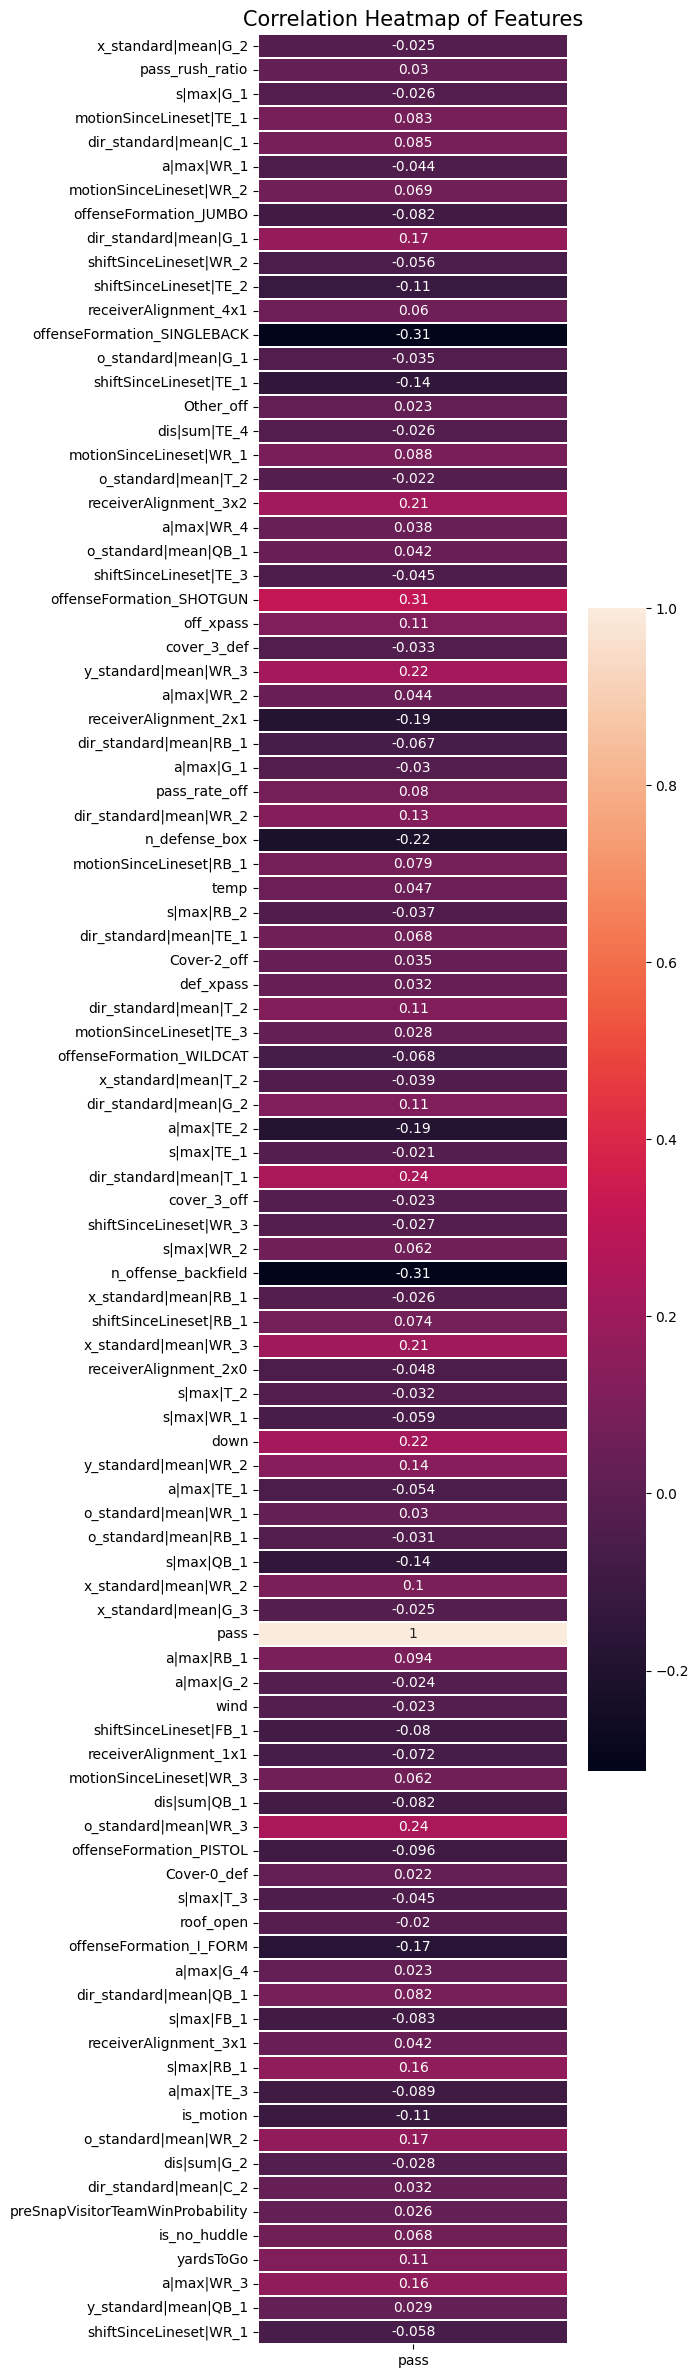

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,30))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(merged_pivot[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [43]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer


# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('pipe',Pipeline([('imputer', imputer),
        ('scaler', MinMaxScaler())]), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [44]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=merged_pivot[final_features].drop(columns='pass')

y=merged_pivot['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 13.37it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


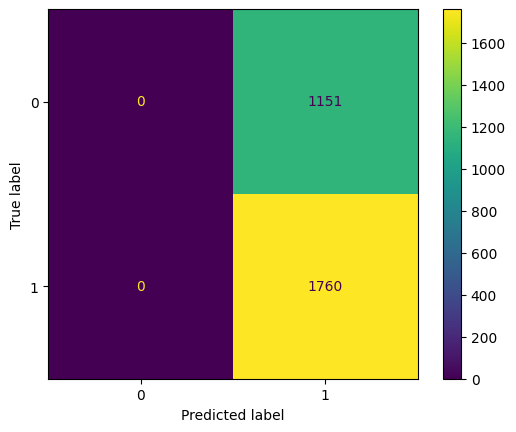

In [45]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits, SEED)

Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

Mean Train AUC --> 0.8976
Mean Validation AUC ---> 0.7862
Mean Train Accuracy --> 0.9030
Mean Validation Accuracy ---> 0.7975


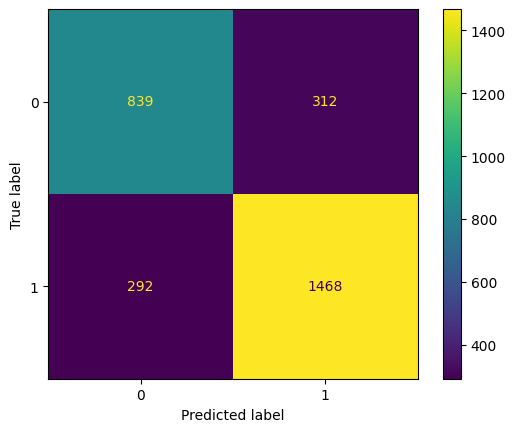

In [46]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
TrainML(pipeline,X, y, n_splits, SEED)

Training Folds: 100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

Mean Train AUC --> 0.9070
Mean Validation AUC ---> 0.7890
Mean Train Accuracy --> 0.9131
Mean Validation Accuracy ---> 0.8013


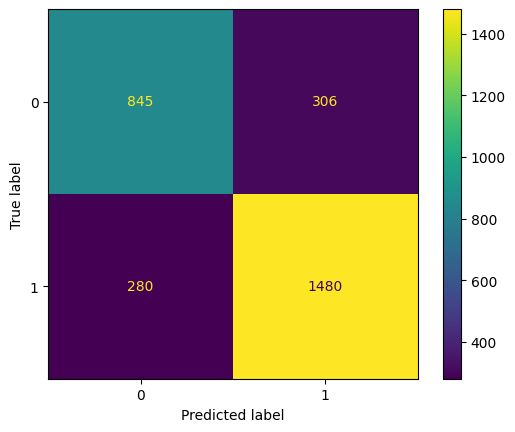

In [47]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  verbose=False))], verbose = True)
TrainML(pipeline,X, y, n_splits, SEED)

In [48]:
X['yardsToGo']=X['yardsToGo'].astype(float)

In [49]:
final_features.remove('pass')

In [50]:
[x for x in numeric_columns if 'FB' in x]

['s|max|FB_1']

In [51]:
#X_transform.isna().sum()

In [52]:
#pd.DataFrame(transformer_impute.fit_transform(X), columns=final_features).isna().sum()

In [53]:
X[numeric_columns].isna().sum().sum()

18012

In [54]:
X.head(1)

,x_standard|mean|G_2,pass_rush_ratio,s|max|G_1,motionSinceLineset|TE_1,dir_standard|mean|C_1,a|max|WR_1,motionSinceLineset|WR_2,offenseFormation_JUMBO,dir_standard|mean|G_1,shiftSinceLineset|WR_2,...,is_motion,o_standard|mean|WR_2,dis|sum|G_2,dir_standard|mean|C_2,preSnapVisitorTeamWinProbability,is_no_huddle,yardsToGo,a|max|WR_3,y_standard|mean|QB_1,shiftSinceLineset|WR_1
0,0.0,2.72,1.84,0,150.675208,2.78,0,False,120.654722,0,...,0,71.078472,0.0,157.848472,0.586653,0,10.0,2.71,23.732569,0


bool


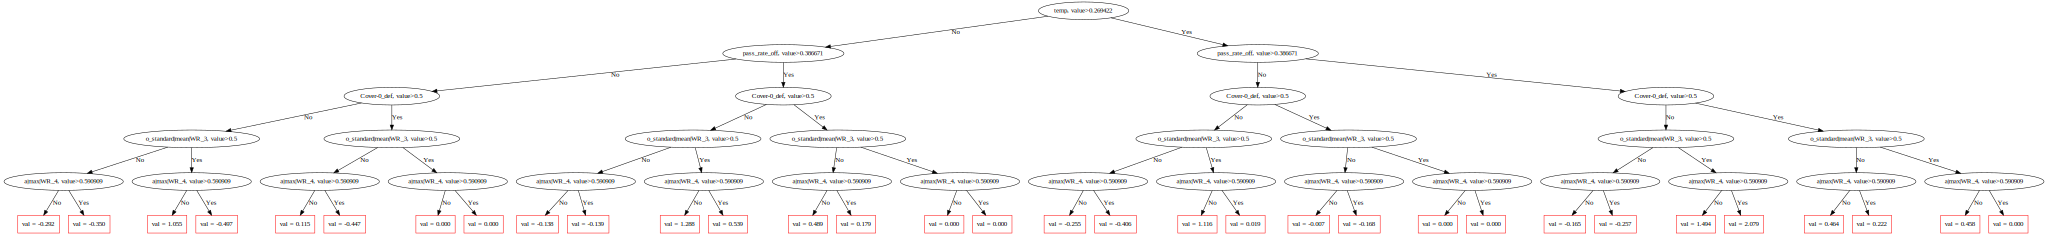

In [55]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline

# For explicitly displaying widgets
from IPython.display import display


X=merged_pivot[final_features]

y=merged_pivot['pass']
numeric_columns=[]
is_cat = (X.dtypes != float)
print(X['offenseFormation_I_FORM'].dtype)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna(0, inplace=True)
    else:
        numeric_columns.append(feature)
        
from sklearn.compose import ColumnTransformer

# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('pipe',Pipeline([('imputer', imputer),
        ('scaler', MinMaxScaler())]), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

X_transform=transformer.fit_transform(X)

X_transform = pd.DataFrame(X_transform, columns=final_features)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X_transform[feature]=X_transform[feature].astype(int)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X_transform, y, cat_features=cat_features_index, feature_names=list(X_transform.columns))



model = CatBoostClassifier( max_depth=5,
    verbose=False,  iterations=2).fit(pool)

model.plot_tree(
    tree_idx=1,
    pool=pool
)

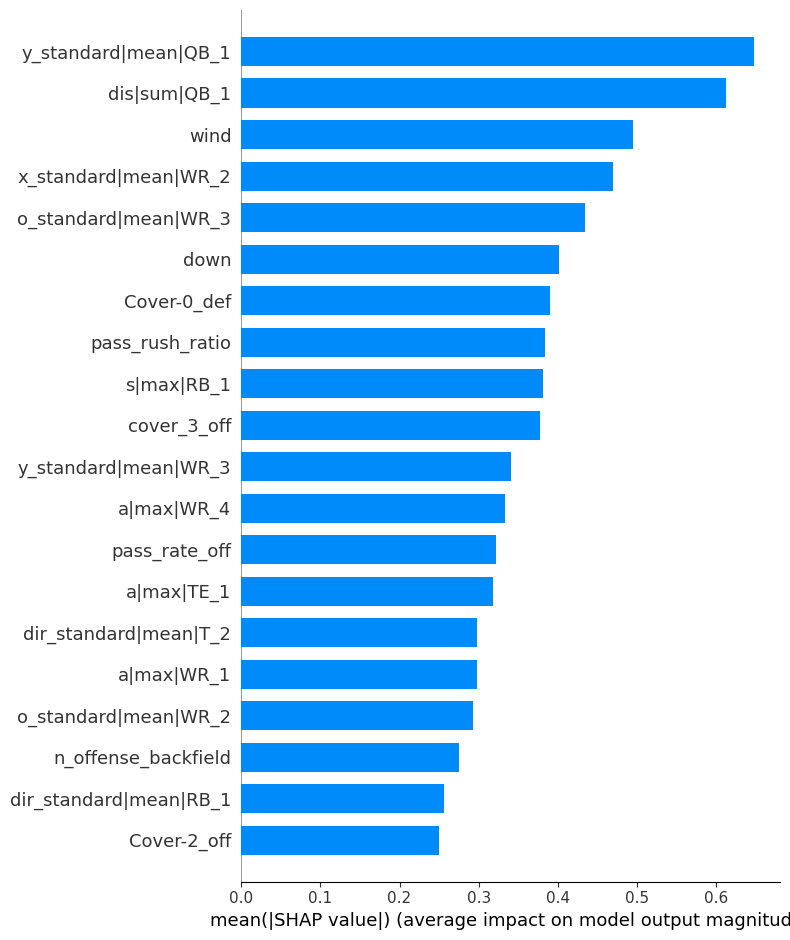

In [56]:
import shap
model = CatBoostClassifier( 
    verbose=False).fit(pool)
shap_values = model.get_feature_importance(Pool(X, label=y, cat_features=cat_features_index),type="ShapValues")
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X, plot_type="bar")

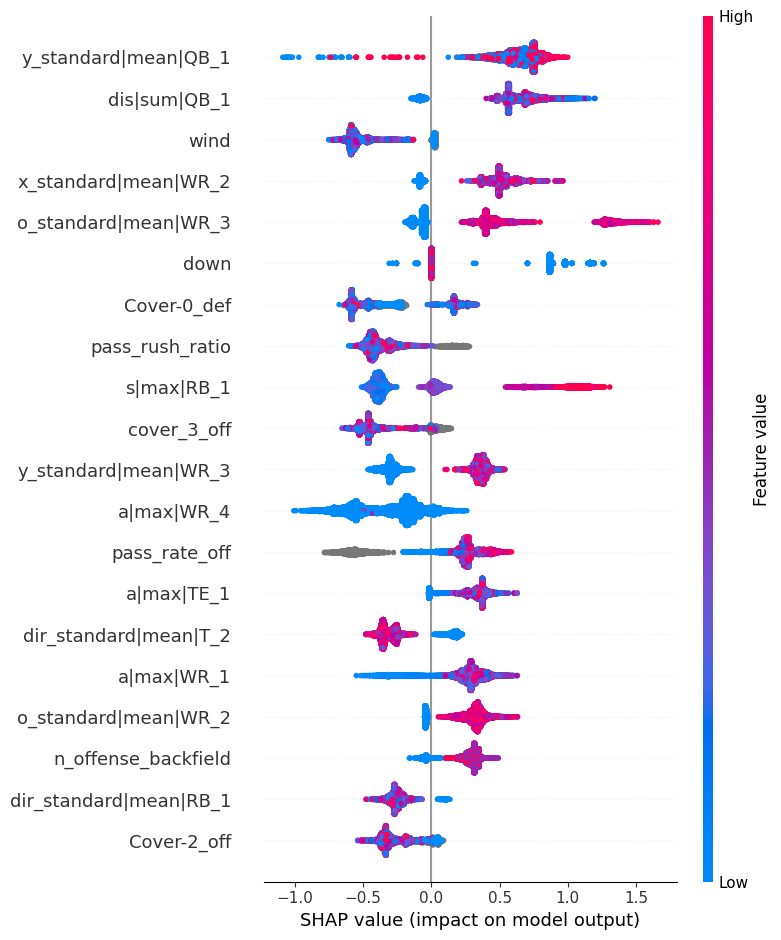

In [57]:
shap.summary_plot(shap_values, X)

In [58]:
importances =model.get_feature_importance(type='PredictionValuesChange')
feature_importances=pd.Series(importances, index=X.columns).sort_values()
feature_importance_df=pd.DataFrame(feature_importances, columns=[ 'importance']).sort_values('importance', ascending=False)
selected_features=list(feature_importance_df.head(len(final_features)).T.columns)
top_30_features=list(feature_importance_df.head(30).T.columns)
top_30_features.append('pass')

In [59]:
list(top_30_features)

['o_standard|mean|WR_3',
 's|max|RB_1',
 'Cover-0_def',
 'y_standard|mean|QB_1',
 'a|max|WR_4',
 'pass_rate_off',
 'o_standard|mean|WR_1',
 'x_standard|mean|WR_2',
 'o_standard|mean|QB_1',
 'x_standard|mean|T_2',
 'y_standard|mean|WR_3',
 'a|max|WR_1',
 's|max|T_2',
 'pass_rush_ratio',
 'cover_3_def',
 'receiverAlignment_1x1',
 'dir_standard|mean|WR_2',
 'dis|sum|QB_1',
 'o_standard|mean|T_2',
 'o_standard|mean|RB_1',
 'a|max|G_1',
 'Cover-2_off',
 'o_standard|mean|G_1',
 'x_standard|mean|G_3',
 'def_xpass',
 'yardsToGo',
 'motionSinceLineset|WR_3',
 's|max|G_1',
 'n_defense_box',
 'off_xpass',
 'pass']

In [60]:
%%capture
!pip install pandas numpy matplotlib seaborn holoviews
!pip install autoviz
from autoviz.AutoViz_Class import AutoViz_Class

In [61]:
'''
%matplotlib inline

AV = AutoViz_Class()

AV.AutoViz("", dfte=merged_pivot[top_30_features].corr(), depVar='pass', verbose=0)
'''

'\n%matplotlib inline\n\nAV = AutoViz_Class()\n\nAV.AutoViz("", dfte=merged_pivot[top_30_features].corr(), depVar=\'pass\', verbose=0)\n'

In [62]:
final_cat_columns=[]
for c in cat_columns:
    if c in selected_features:
        final_cat_columns.append(c)

In [63]:
final_numeric_columns=[]
for i in selected_features:
       if merged_pivot[i].dtype!='O' and i!='pass' and 'shiftSinceLineset' not in i and 'motionSinceLineset' not in i and  'offenseFormation' not in i and'receiverAlignment'not in i and 'Cover'not in i and 'roof' not in i and 'surface' not in i and 'is_no_huddle' not in i and 'is_no_motion' not in i:
            final_numeric_columns.append(i)
    

In [64]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('pipe',Pipeline([('imputer', imputer),
        ('scaler', MinMaxScaler())]), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

### Note: deprecate 'objective'? (not using the tune below)

In [65]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
X=merged_pivot[selected_features]

y=merged_pivot['pass']
# Define the helper function so that it can be reused

cat_params = optuna_call(transformer,X,y,SKF,n_trials=5)

[I 2024-10-24 14:44:41,757] A new study created in memory with name: no-name-4c394631-8834-43ea-b9f2-ac0e6c600f34


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-10-24 14:44:58,461] Trial 0 finished with value: 0.7833883460236087 and parameters: {'learning_rate': 0.02102343005909589, 'depth': 8, 'subsample': 0.5256032163728864, 'colsample_bylevel': 0.22562891565556514, 'iterations': 387}. Best is trial 0 with value: 0.7833883460236087.
[I 2024-10-24 14:45:48,577] Trial 1 finished with value: 0.8024181439481165 and parameters: {'learning_rate': 0.08282183617767876, 'depth': 9, 'subsample': 0.6329363980748302, 'colsample_bylevel': 0.39815405572722623, 'iterations': 598}. Best is trial 1 with value: 0.8024181439481165.
[I 2024-10-24 14:46:05,588] Trial 2 finished with value: 0.7997386523644683 and parameters: {'learning_rate': 0.0905825529539595, 'depth': 7, 'subsample': 0.4769426476206388, 'colsample_bylevel': 0.27054322400178105, 'iterations': 573}. Best is trial 1 with value: 0.8024181439481165.
[I 2024-10-24 14:46:17,468] Trial 3 finished with value: 0.8051659393509274 and parameters: {'learning_rate': 0.08664096447957581, 'depth': 5, 

In [66]:
1

1

In [67]:
#cat_params={'learning_rate': 0.09266434349818461, 'depth': 8, 'subsample': 0.9490011978490482, 'colsample_bylevel': 0.8112961715549822, 'iterations': 469}

In [68]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  **cat_params, verbose=False))], verbose = True)
TrainML(pipeline,X, y, n_splits, SEED)

Training Folds: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]

Mean Train AUC --> 0.9260
Mean Validation AUC ---> 0.7932
Mean Train Accuracy --> 0.9312
Mean Validation Accuracy ---> 0.8052


In [69]:
uniqueplays=len(merged_pivot)
playswithpasses=len(merged_pivot[merged_pivot['pass']==1])

print('Unique plays:' , uniqueplays)
print('Unique plays with passes:' ,playswithpasses )
print('% Plays with Pass Attempts: ', round((playswithpasses/uniqueplays)*100, 1), '%')

Unique plays: 14556
Unique plays with passes: 8801
% Plays with Pass Attempts:  60.5 %


In [70]:
# Create a transformer
imputer = SimpleImputer(strategy='mean')
transformer = ColumnTransformer([#('imputer', imputer, final_numeric_columns)#,
        #('scaler', MinMaxScaler(), final_features)
                                 ('pipe_num',Pipeline([('imputer', imputer),('scaler', MinMaxScaler())]),final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [71]:
X=merged_pivot[selected_features]

y=merged_pivot['pass']



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,stratify=y_temp,  test_size=0.5, random_state=42)


In [72]:
tf.random.set_seed(42)
# Define the MLP model
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the epoch with the best value of the monitored quantity
)

imputer_k = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

scaler=MinMaxScaler()
transformer.fit(X_train)
imputer_k.fit(X_train)
X_train_scaled = imputer_k.transform(transformer.transform(X_train))
X_val_scaled =imputer_k.transform(transformer.transform(X_val))
X_test_scaled = imputer_k.transform(transformer.transform(X_test))

model = Sequential()

model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(8, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(1, activation='sigmoid'))
initial_weights = model.get_weights()
optimizer = keras.optimizers.Adam(.0004)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [73]:
accuracy1_mlp, f1_1_mlp, precision1_mlp, recall1_mlp, roc = calculate_and_plot_metrics(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, "Pass Probability Keras MLP",model, early_stopping)


print(f"Accuracy: {accuracy1_mlp:.4f}\nF1 Score: {f1_1_mlp:.4f}\nPrecision: {precision1_mlp:.4f}\nRecall: {recall1_mlp:.4f}\nROC AUC: {roc:.4f}\n")

Epoch 1/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.6024 - loss: 0.6622 - val_accuracy: 0.7343 - val_loss: 0.5535
Epoch 2/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7318 - loss: 0.5485 - val_accuracy: 0.7586 - val_loss: 0.5097
Epoch 3/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.7476 - loss: 0.5155 - val_accuracy: 0.7636 - val_loss: 0.5017
Epoch 4/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7554 - loss: 0.5011 - val_accuracy: 0.7636 - val_loss: 0.4912
Epoch 5/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.7606 - loss: 0.4915 - val_accuracy: 0.7687 - val_loss: 0.4873
Epoch 6/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.7665 - loss: 0.4815 - val_accuracy: 0.7696 - val_loss: 0.4801
Epoch 7/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.7685 - loss: 0.4780 - val_accuracy: 0.7691 - val_loss: 0.4782
Epoch 8/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.7705 - loss: 0

In [74]:
from tensorflow.keras.utils import plot_model
 #Plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
